**Data**

We start handling the data by importing python libraries and the Kaggle dataset. 

Kaggle Dataset Link: https://www.kaggle.com/datasets/rtlmhjbn/ip02-dataset 

In [1]:
#!pip install opendatasets 
#!pip install pandas
#!pip install timm
#!pip install opencv-python

In [2]:
#os.environ['CUDA_LAUNCH_BLOCKING'] = 1
import joblib
from skimage.io import imread
from skimage.transform import resize
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import pprint
pp = pprint.PrettyPrinter(indent=4) 
from tqdm import tqdm
from textwrap import wrap
import random
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.functional as F
#import albumentations as A
#from albumentations.pytorch.transforms import ToTensorV2

import timm

In [3]:
import opendatasets as od
import pandas
od.download('https://www.kaggle.com/datasets/rtlmhjbn/ip02-dataset/code?select=classification')

Skipping, found downloaded files in "./ip02-dataset" (use force=True to force download)


In [4]:
f = open('ip02-dataset/classes.txt')
label = []
name = []
for line in f.readlines():
    label.append(int(line.split()[0]))
    name.append(' '.join(line.split()[1:]))
classes = pd.DataFrame([label, name]).T
classes.columns = ['label','name']
classes

,label,name
0,1,rice leaf roller
1,2,rice leaf caterpillar
2,3,paddy stem maggot
3,4,asiatic rice borer
4,5,yellow rice borer
...,...,...
97,98,Chlumetia transversa
98,99,Mango flat beak leafhopper
99,100,Rhytidodera bowrinii white
100,101,Sternochetus frigidus


The problem with this dataset is that due to the large sum of data and the high dimensionality of the inputs, the model is hard to make computationally efficient and iterations take a long time to run. Our preliminary base model is a Resnet34 which is a convolutional neural network that utilizes residual blocks to take in an input image of 34x34 and output a classification. All input images are resized into a 34x34 image in order to feed this into the NN. 

In [5]:

def resize_all(src, width=64, height=None):
    """
    load images from path, resize them and write them as arrays to a dictionary, 
    together with labels and metadata. The dictionary is written to a pickle file 
    named '{pklname}_{width}x{height}px.pkl'.
     
    Parameter
    ---------
    src: str
        path to data
    pklname: str
        path to output file
    width: int
        target width of the image in pixels
    include: set[str]
        set containing str
    """
     
    height = height if height is not None else width
     
    traindata = dict()
    traindata['description'] = 'resized ({0}x{1})insect images in rgb'.format(int(width), int(height))
    traindata['label'] = []
    traindata['filename'] = []
    traindata['data'] = []   
    testdata = dict()
    testdata['description'] = 'resized ({0}x{1})insect images in rgb'.format(int(width), int(height))
    testdata['label'] = []
    testdata['filename'] = []
    testdata['data'] = []   
    valdata = dict()
    valdata['description'] = 'resized ({0}x{1})insect images in rgb'.format(int(width), int(height))
    valdata['label'] = []
    valdata['filename'] = []
    valdata['data'] = []   
    dicts = [testdata,traindata,valdata]
    #pklname = f"{pklname}_{width}x{height}px.pkl"
    y = 0
    # read all images in PATH, resize and write to DESTINATION_PATH
    for subdir in os.listdir(src):
        print(subdir)
        current_path = os.path.join(src, subdir)
        directory = current_path
        for subdir2 in os.listdir(current_path):
            print(current_path)
            current_path = os.path.join(directory, subdir2)
            for file in os.listdir(current_path):
                if file[-3:] in {'jpg', 'png'}:
                    im = imread(os.path.join(current_path, file))
                    im = resize(im, (width, height)) #[:,:,::-1]
                    dicts[y]['label'].append(subdir2)
                    dicts[y]['filename'].append(file)
                    dicts[y]['data'].append(im)
        y += 1
        #joblib.dump(data, pklname)
    return dicts

In [6]:
data_path = 'ip02-dataset/classification'
stuff = os.listdir(data_path)
print(len(stuff))

3


In [7]:
def resample(dataFrame,percentage,):
    sample = int(percentage * len(dataFrame))
    x = np.random.randint(len(dataFrame),size =sample)
    newdf = dataFrame.drop(index = x, axis=0)
    return newdf
train_df = pd.read_csv('ip02-dataset/train.txt',sep=' ',header=None, engine='python')
train_df = train_df.sample(frac=.10)
train_df.columns = ['image_path','label']
test_df = pd.read_csv('ip02-dataset/test.txt',sep=' ',header=None, engine='python')
test_df = test_df.sample(frac=.10)
test_df.columns = ['image_path','label']

val_df = pd.read_csv('ip02-dataset/val.txt',sep=' ',header=None, engine='python')
val_df = val_df.sample(frac=.10)
val_df.columns = ['image_path','label']

print(len(train_df))
print(len(test_df))
print(len(val_df))
train_df.head()

4510
2262
751


,image_path,label
25893,43193.jpg,62
39587,66036.jpg,92
6469,10792.jpg,15
23037,38423.jpg,51
9825,16422.jpg,23


In [8]:
TRAIN_DIR = 'ip02-dataset/classification/train'
TEST_DIR = 'ip02-dataset/classification/test'
VAL_DIR = 'ip02-dataset/classification/val'
LR = 2e-5
BATCH_SIZE = 4
EPOCH = 2
print_every = 100
dtype = torch.float32
device = torch.device('cuda')

**Preliminary**

We use Convolutional Neural Network (CNN) to classify multi-layer data. The dataset contains over 75k images and about 737 samples per a class. This is suitable to work with for solving a problem such as multi class classification, as there is a large amount of data for the model to generalize from. 

Here, we define three functions below for our image classification process: 

* *InsectModel* uses the vision transformer based size model to classify our insect images
* *ThreeLayerConvNet* applies convolutions for image classification
* *InsectDataset* loading preprocessing image 

In [9]:
class InsectModel(nn.Module):
    def __init__(self,num_classes):
        super(InsectModel, self).__init__()
        self.num_classes = num_classes
        self.model = timm.create_model('vit_base_patch16_224',pretrained=True,num_classes=num_classes)
    def forward(self, image):
        return self.model(image)

In [10]:
class ThreeLayerConvNet(nn.Module):
    def __init__(self, in_channel, channel_1, channel_2, num_classes):
        super().__init__()
      
        self.conv_1 = nn.Conv2d(in_channel, channel_1, (5,5), padding=2)
        nn.init.kaiming_normal_(self.conv_1.weight)
        self.conv_2 = nn.Conv2d(channel_1, channel_2, (3,3), padding=1)
        nn.init.kaiming_normal_(self.conv_2.weight)

        self.fc1 = nn.Linear(73984, 4)
        self.relu = nn.ReLU(inplace=True)
        


    def forward(self,x):
        scores = None
        ########################################################################
        # TODO: Implement the forward function for a 3-layer ConvNet. you      #
        # should use the layers you defined in __init__ and specify the        #
        # connectivity of those layers in forward()                            #
        ########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        x = self.relu(self.conv_2(self.relu((self.conv_1(x)))))
        x = flatten(x)
        scores = self.fc1(x)
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################
        return scores

The data is also transformed in a variety of psuedo random ways. The transforms that are applied to the input data are; a random vertical flip, a random adjustment to the sharpness, a random horizontal flip and color jitter. These flip transformations are used to increase the datasets size during training and also reduce overfitting and introduce diversity allowing the model to better generalize.

In [11]:
data_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.RandomVerticalFlip(),
                                     transforms.RandomAdjustSharpness(sharpness_factor=1.5),
                                     transforms.RandomHorizontalFlip(),
                                     transforms.ColorJitter(),
                                     transforms.Resize((224,224))])


In [12]:
#data_transform = transforms.Compose([transforms.ToTensor(),
                                     #transforms.Resize((224,224))])

In [13]:
class InsectDataset(Dataset):
    def __init__(self, image, image_dir, transforms=None):
        self.image_info = image
        self.transforms = transforms
        self.imgdir = image_dir
    def __len__(self):
        return self.image_info.shape[0]
    def __getitem__(self, index):
        image_info = self.image_info[index]
        image = cv2.imread(os.path.join(self.imgdir,str(image_info[1]),image_info[0]),cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.
        
        if self.transforms is not None:
            image = self.transforms(image)
        
        label = image_info[1]
        
        image = torch.as_tensor(image, dtype=torch.float32)
        label = torch.as_tensor(label, dtype=torch.long)
        return image, label

In [14]:
train_dataset = InsectDataset(image=train_df.values, 
                              image_dir=TRAIN_DIR, 
                              transforms=data_transform)
train_loader = DataLoader(train_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=2)
val_dataset = InsectDataset(image=val_df.values,
                            image_dir=VAL_DIR,
                            transforms=data_transform)
valid_loader = DataLoader(val_dataset,
                             batch_size=BATCH_SIZE,
                             shuffle=True,
                             num_workers=2)

Here is our sample images from the dataset which has already been resized.

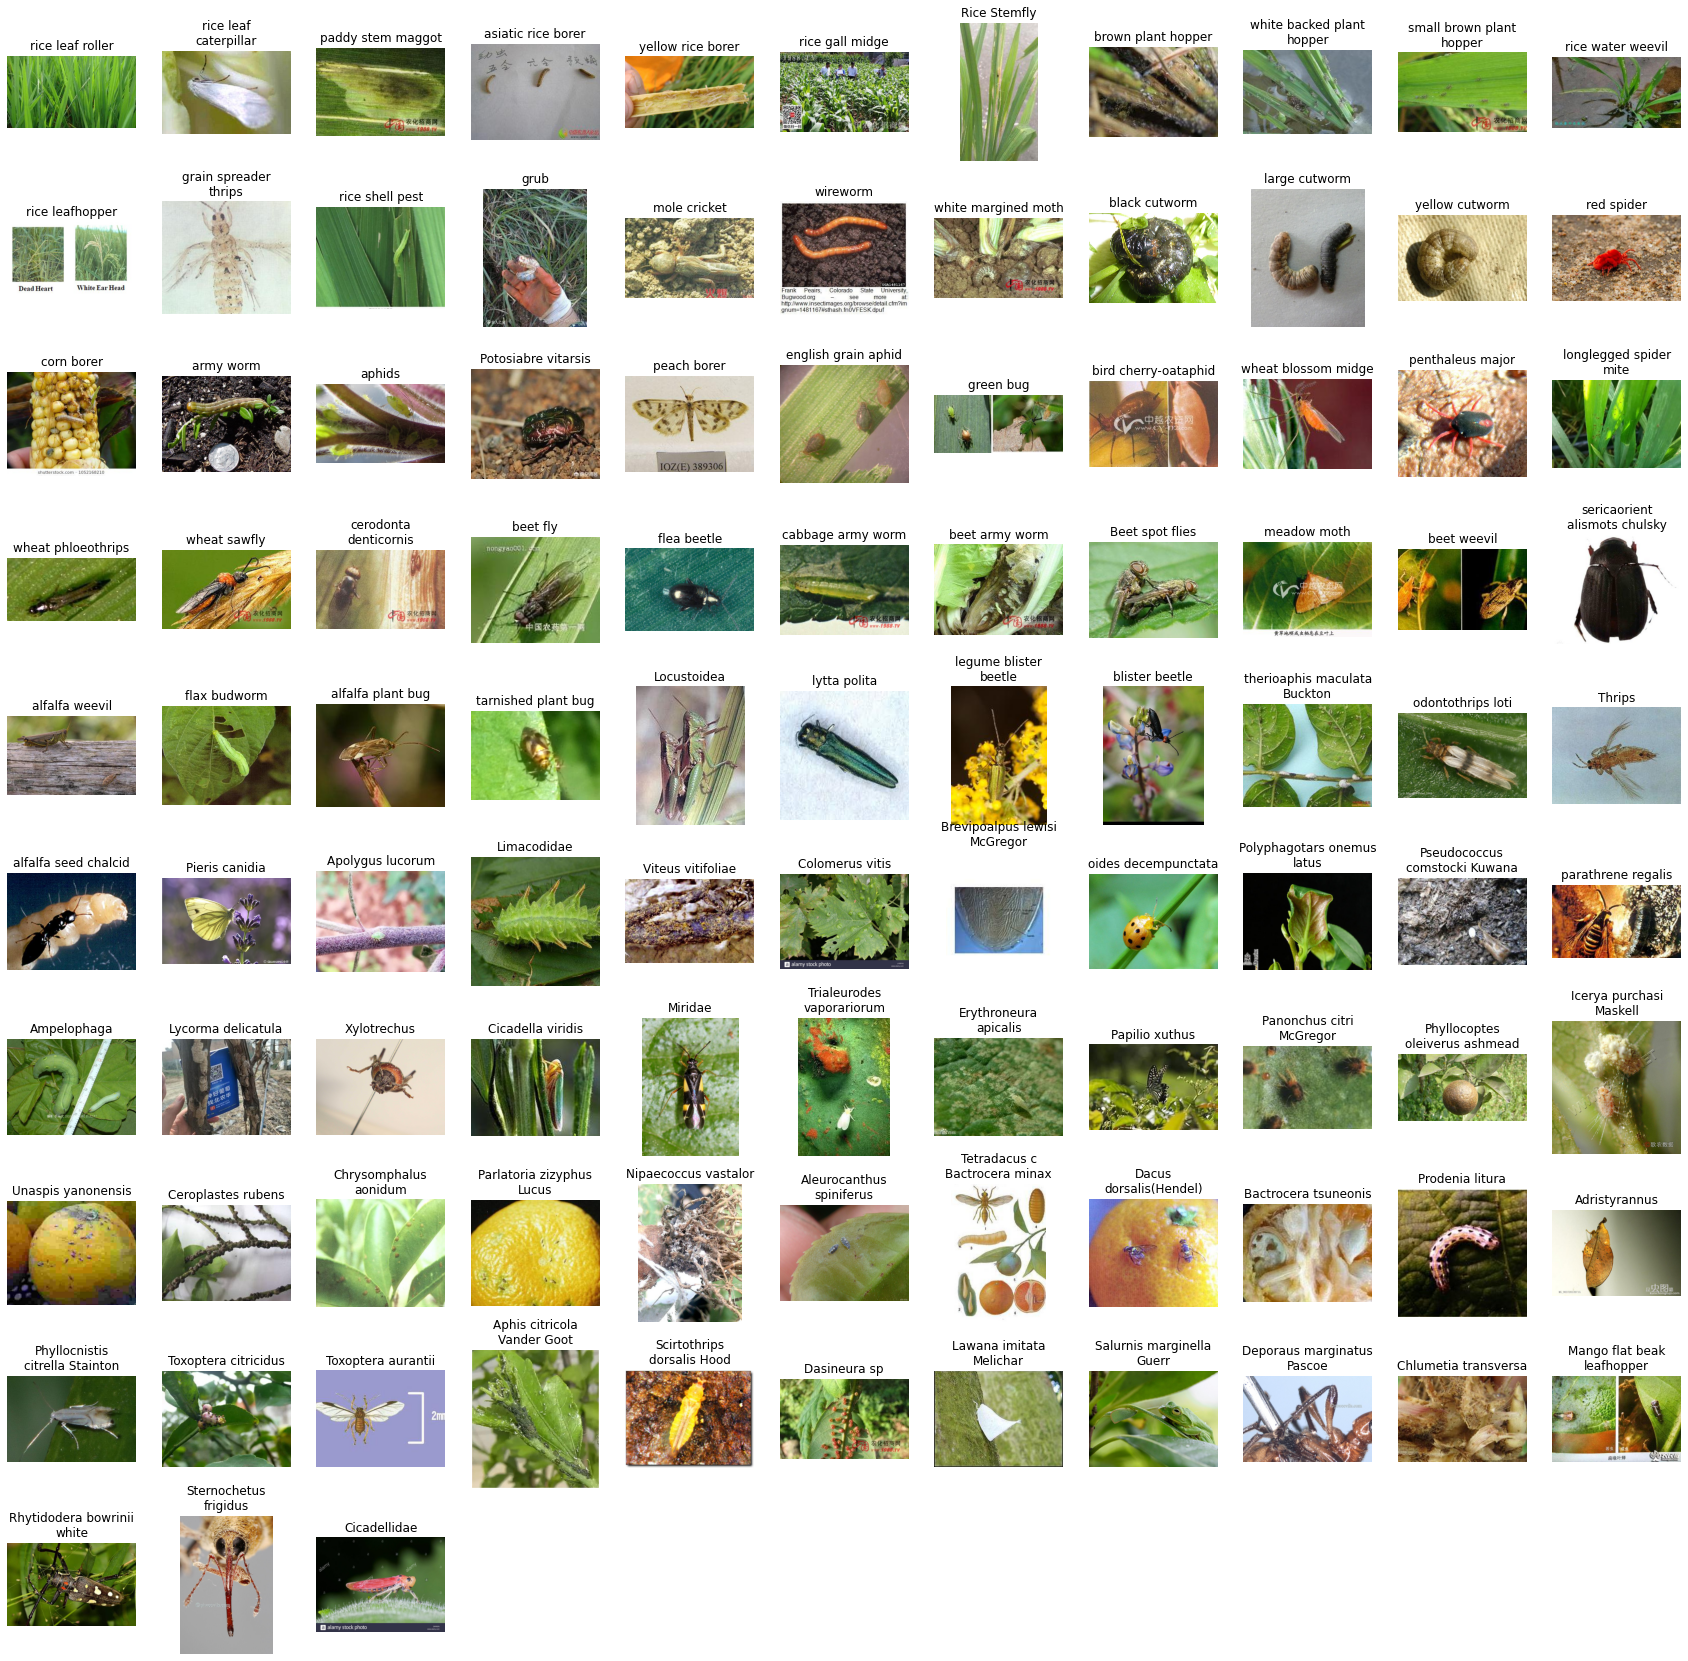

In [15]:
fig, axs = plt.subplots(10,11,figsize=(30,30))
images = []
for i in classes.label:
    random_img = random.choice(train_df[train_df.label==i-1].image_path.values)
    label = classes.name[i-1]
    img = plt.imread(os.path.join(TRAIN_DIR,str(i-1),random_img))
    images.append(img)

[ax.imshow(image) for image,ax in zip(images,axs.ravel())]
[ax.set_title("\n".join(wrap(label,20))) for label,ax in zip(list(classes.name),axs.ravel())]
[ax.set_axis_off() for ax in axs.ravel()]
plt.show()

In [16]:
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.loss = 0
        self.correct = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, loss,correct, n=1):
        self.loss = loss
        self.correct += correct
        self.sum += loss * n
        self.count += n
        
        self.avg = self.sum / self.count
        self.acc = self.correct / self.count
        
class Accuracy(object):
    def __init__(self):
        self.reset

In [17]:
def train_fn(data_loader, model, criterion, device, optimizer, epoch):
    model.train()
    criterion.train()
    
    summary = AverageMeter()
    tk0 = tqdm(data_loader, total=len(data_loader))
    for step, (images, labels) in enumerate(tk0):
        images = images.to(device, non_blocking = True).float()
        labels = labels.to(device, non_blocking = True).long()
    
        output = model(images)
        loss = criterion(output, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        preds = output.softmax(1).argmax(1)
        correct = (preds == labels).sum().item()
        
        summary.update(loss.item(),correct, BATCH_SIZE)
        tk0.set_postfix(loss=summary.avg, acc=summary.acc, epoch=epoch+1)
    return summary

def eval_fn(data_loader, model, criterion, device, epoch):
    model.eval()
    criterion.eval()
    
    summary = AverageMeter()
    tk0 = tqdm(data_loader, total=len(data_loader))
    with torch.no_grad():
        for step, (images, labels) in enumerate(tk0):
            images = images.to(device, non_blocking = True).float()
            labels = labels.to(device, non_blocking = True).long()
            
            output = model(images)
            loss = criterion(output, labels)
            
            preds = output.softmax(1).argmax(1)
            correct = (preds == labels).sum().item()
            
            summary.update(loss.item(), correct, BATCH_SIZE)
            tk0.set_postfix(loss=summary.avg, acc=summary.acc, epoch=epoch+1)
    return summary

In [18]:
#os.environ['WANDB_CONSOLE'] = 'off'
def run():
    model = InsectModel(num_classes=102)
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    criterion = criterion.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
    best_loss = 10**5
    for epoch in range(0, EPOCH):
        train_loss = train_fn(train_data_loader, model, criterion, device, optimizer, epoch)
        val_loss = eval_fn(val_data_loader, model, criterion, device, epoch)
        if val_loss.avg < best_loss:
            best_loss = val_loss.avg
            torch.save(model.state_dict(), f'vit_best.pth')
        print(f'Epoch {epoch+1+0:03}: | Train Loss: {train_loss.avg:.5f} | Val Loss: {val_loss.avg:.5f}')

In [19]:
#run()

Now, we evaluate the accuracy of our chosen model.

In [20]:
def check_accuracy_part34(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            #f1_scores.append(f1_score(y.cpu().detach().numpy(),preds,average = 'micro'))
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        acc_list.append(acc)
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))

In [21]:
def flatten(x):
    N = x.shape[0] # read in N, C, H, W
    return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

We train model using epoch hyperparameter, which means that the algorithm will loop through the entire training dataset. We also use backward pass method to propagate the error whlie training.

In [22]:
iter_list = []
acc_list = []
loss_list = []
labels = np.arange(102)
f1_scores = []
from sklearn.metrics import f1_score
def train_part34(model, optimizer, epochs=1):
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        for t, (x, y) in enumerate(train_loader):
            #print(1)
            
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype).float()  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.cross_entropy(scores, y)
            #f1_scores = f1_score(y.cpu().detach().numpy(),host_scores,average = 'micro',labels = labels)
            # Zero out all the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()
            if t % print_every == 0:
                loss_list.append(loss.item())
                print('Epoch %d, Iteration %d, loss = %.4f' % (e, t, loss.item()))
                check_accuracy_part34(valid_loader, model)
                iter_list.append(t)
                print()

In [23]:
#timm.list_models()

In [24]:
channel_1 = 34
channel_2 = 68
model = InsectModel(102)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
#print(train_loader)
train_part34(model, optimizer, epochs=1)

Epoch 0, Iteration 0, loss = 4.9527
Got 20 / 751 correct (2.66)

Epoch 0, Iteration 100, loss = 2.3485
Got 188 / 751 correct (25.03)

Epoch 0, Iteration 200, loss = 3.6561
Got 221 / 751 correct (29.43)

Epoch 0, Iteration 300, loss = 3.4488
Got 262 / 751 correct (34.89)

Epoch 0, Iteration 400, loss = 2.5339
Got 297 / 751 correct (39.55)

Epoch 0, Iteration 500, loss = 1.5595
Got 309 / 751 correct (41.15)

Epoch 0, Iteration 600, loss = 2.5704
Got 346 / 751 correct (46.07)

Epoch 0, Iteration 700, loss = 2.1730
Got 332 / 751 correct (44.21)

Epoch 0, Iteration 800, loss = 3.3043
Got 348 / 751 correct (46.34)

Epoch 0, Iteration 900, loss = 0.0583
Got 370 / 751 correct (49.27)

Epoch 0, Iteration 1000, loss = 3.6356
Got 364 / 751 correct (48.47)

Epoch 0, Iteration 1100, loss = 1.1753
Got 377 / 751 correct (50.20)



[]


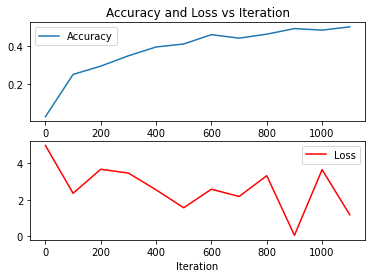

In [25]:
print(f1_scores)
fig,ax = plt.subplots(2)
ax[0].set_title('Accuracy and Loss vs Iteration')
ax[0].plot(iter_list,acc_list,label = 'Accuracy')
ax[1].plot(iter_list,loss_list,label = 'Loss',c = 'r')
ax[0].legend()
ax[1].legend()
#plt.ylabel("Accuracy")
plt.xlabel("Iteration")

acc_list = np.array(acc_list)
#print(acc_list[acc_list.argmax()])

In [26]:
model = InsectModel(num_classes=102)
model.load_state_dict(torch.load("./vit_best.pth"))
images, labels = next(iter(val_data_loader))
preds = model(images).softmax(1).argmax(1)

fig, axs = plt.subplots(2,4,figsize=(13,8))
[ax.imshow(image.permute((1,2,0))) for image,ax in zip(images,axs.ravel())]
[ax.set_title("\n".join(wrap(f'Accutual: {classes.name[label.item()]} Predicted: {classes.name[pred.item()]}',30)),color = 'g' if label.item()==pred.item() else 'r') for label,pred,ax in zip(labels,preds,axs.ravel())]
[ax.set_axis_off() for ax in axs.ravel()]
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: './vit_best.pth'

Based on our findings, we get 60% accuracy on our testing. 